#### Hartree-Fock in Pytorch

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/cki'


SPS=SingleParticleState(file_name=file_name)

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.17it/s]


In [3]:
nparticles_a=4
nparticles_b=4

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [4]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  7.70it/s]
1424it [00:02, 567.92it/s]


[-71.09941964]
total_m= [-1.37476835e-16]
dimension= 51


Hartree-Fock method

In [5]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=6)


In [6]:

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

tensor(8.3393, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(14.2839, dtype=torch.float64, grad_fn=<DotBackward0>) tensor(-65.0339, dtype=torch.float64, grad_fn=<AddBackward0>)
Step    0 | Energy = -50.750016
tensor(8.3469, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(14.2663, dtype=torch.float64, grad_fn=<DotBackward0>) tensor(-65.3127, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.3523, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(14.2486, dtype=torch.float64, grad_fn=<DotBackward0>) tensor(-65.5996, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.3555, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(14.2311, dtype=torch.float64, grad_fn=<DotBackward0>) tensor(-65.8941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.3564, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(14.2139, dtype=torch.float64, grad_fn=<DotBackward0>) tensor(-66.1965, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.3551, dtype=torch.float64, grad_fn=<SumBackw

In [7]:
print(torch.sum(torch.abs(model.C_p)))

tensor(8.4666, dtype=torch.float64, grad_fn=<SumBackward0>)


In [8]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p

    return psi  # [F]


In [9]:

psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)



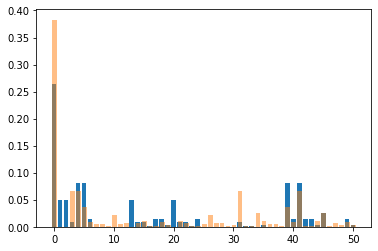

-68.43454983822271
fidelity= 0.5815258009721019


In [10]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [11]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C_p))

True


#### Sample Based Diagonalization HF and exact Gs

In [12]:
n_instances=9000

In [13]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]
nbatch=50
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],1)
errors_sdg_gs=[]
energies_sdg_gs=[]
fidelities_exact=[]

deviations_exact=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_exact.append(ensamble_fidelity)
        errors_sdg_gs.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_gs.append(ensamble_energy)
        deviations_exact.append(std_energy)
        print(ensamble_energy)


-57.652673724256445
-60.58324233901623
-60.973984187014175
-62.51250905547741
-62.53125788835573
-63.84973506208638
-64.33828544953552
-64.63262462091629
-65.19315754811552
-65.59552174814843
-65.83069334125301
-66.09347770250139
-66.63435429179667
-66.8488209846563
-67.13918430868758
-67.30997290264425
-67.39857379669792
-67.69430347667607
-67.95041325682442
-68.00077791800993
-68.18023694477814
-68.38547528937923
-68.62571874978542
-68.79384379892312
-68.85135189253282
-69.00840454658314
-69.19479368887579
-69.28472204835505
-69.41508413719166
-69.54732285330641
-69.66422720654413
-69.79150615853719
-69.88829803771414
-70.01687092924614
-70.13281327100835
-70.24654486551809
-70.34576438025881
-70.41666815117618
-70.5109799237076
-70.64788405453409
-70.71560887824269
-70.80434178107056
-70.88377089805138
-70.95618730616579
-71.03383395135101
-71.09941963793389
-71.0994196379339
-71.09941963793389
-71.09941963793389


In [14]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]

deviations=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities.append(ensamble_fidelity)
        errors_sdg_hf.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf.append(ensamble_energy)
        deviations.append(std_energy)
        print(ensamble_energy)


-56.20949334307974
-58.4593334426705
-60.1625866398187
-61.28137992600666
-61.515456192960855
-62.31381248584196
-62.88967564336809
-63.61282043053415
-64.39662966646321
-64.93742076330231
-64.95422494377323
-65.29035600094409
-65.76188798963541
-65.8134761589501
-66.21416933337984
-66.48792202047579
-66.74915109753701
-66.85949028749836
-67.2690643307916
-67.31047944705429
-67.59520998230029
-67.84937391554139
-68.11316588198741
-68.18929085493082
-68.39836476062213
-68.65193519861732
-68.75055114723867
-68.96294474626698
-69.04709143021108
-69.13886273229215
-69.22263149697959
-69.34919321950467
-69.39520905941895
-69.41257463806956
-69.44254067252058
-69.47540038074914
-69.51131028830672
-69.5468251334954
-69.61027643392545
-69.70643603734204
-69.79855159090306
-69.85105660008917
-69.98717288854806
-70.07998087415673
-70.21996185057957
-70.28533517422258
-70.37978030388521
-70.51053102045682
-70.66700037694571


Useless

In [ ]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_clever=[]
energies_sdg_hf_clever=[]
fidelities_clever=[]
max_iterations=100
prob_sampler=prob_hf.copy()
ns_instances_clever=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],5)
selection=np.random.choice(np.arange(prob_hf.shape[0]),size=2,replace=False,p=prob_hf)
selected_samples=[selection[0],selection[1]]
effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

prob_sampler[selected_samples]=0
prob_sampler=prob_sampler/np.sum(prob_sampler)

effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
e_old=effective_egs.copy()

for r in range(NSMHamiltonian.hamiltonian.shape[0]-3): 
    
    low_energy=effective_egs.copy()
    for i in range(max_iterations):
        
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=5,replace=False,p=prob_sampler)
        tentative_selection=selected_samples+list(selection)
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[tentative_selection,:][:,tentative_selection]
        egs_tentative,psi0_tentative=eigsh(effective_hamiltonian,k=1,which='SA')

        if effective_egs <= low_energy:
            psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
            final_selection=tentative_selection
            low_energy=effective_egs
            effective_egs=egs_tentative.copy()
            psi_selected[tentative_selection]=psi0_tentative[:,0]
    print(effective_egs)
    selected_samples=final_selection
    prob_sampler[selected_samples]=0
    prob_sampler=prob_sampler/np.sum(prob_sampler)
    fidelities_clever.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
    errors_sdg_hf_clever.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
    energies_sdg_hf_clever.append(effective_egs[0])

    
    

128 127


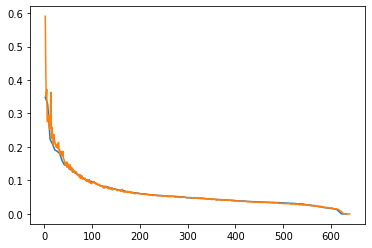

In [28]:
print(len(ns_instances_clever),len(errors_sdg_hf_clever))

plt.plot(ns_instances_clever[:-1],errors_sdg_hf_clever)
plt.plot(ns_instances,errors_sdg_hf)
plt.show()

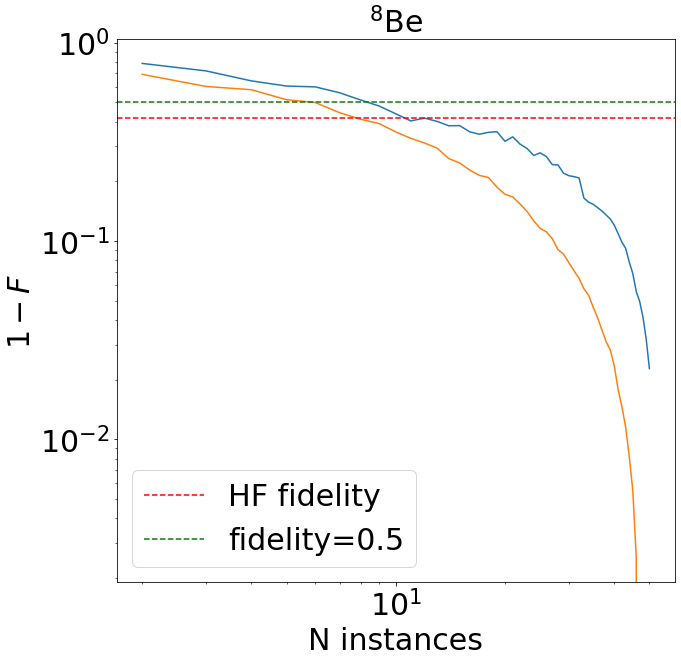

In [16]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')
plt.axhline(y=0.5,label='fidelity=0.5',color='green',linestyle='--')
plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.loglog()
plt.show()

In [17]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_mixed=[]
energies_sdg_hf_mixed=[]
fidelities_mixed=[]
deviations_mixed=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2
        
                
        prob_hf=0.95*prob_hf+0.05*ensamble_prob_selected
        prob_hf=prob_hf/np.sum(prob_hf)
        fidelities_mixed.append(ensamble_fidelity)
        errors_sdg_hf_mixed.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf_mixed.append(ensamble_energy)
        deviations_mixed.append(std_energy)
        print(effective_egs)

[-62.04382578]
[-62.70679627]
[-61.53821682]
[-62.73807342]
[-62.76669556]
[-63.64246414]
[-64.67960634]
[-65.40063605]
[-63.5873912]
[-65.61915399]
[-65.36299264]
[-66.39684371]
[-65.9856056]
[-66.44985606]
[-66.61254006]
[-66.42639549]
[-66.94746684]
[-67.03763342]
[-67.60660851]
[-67.98228107]
[-67.96639076]
[-68.22482002]
[-68.46051546]
[-68.72301384]
[-68.81420106]
[-68.8218194]
[-69.09253009]
[-69.03669644]
[-69.34439648]
[-69.34544112]
[-69.34676178]
[-69.34919322]
[-69.35954434]
[-69.41513857]
[-69.45546687]
[-69.49624101]
[-69.51306389]
[-69.52736665]
[-69.59978026]
[-69.89990306]
[-69.97220308]
[-70.04945705]
[-70.1704901]
[-70.19403469]
[-70.27057574]
[-70.34186621]
[-70.37324598]
[-70.97416554]
[-71.03379057]


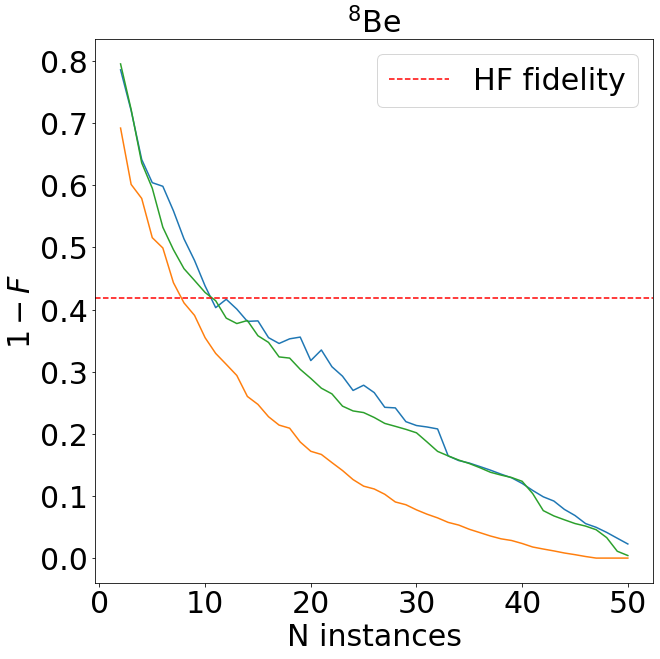

In [18]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)
plt.plot(ns_instances,fidelities_mixed)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')

plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

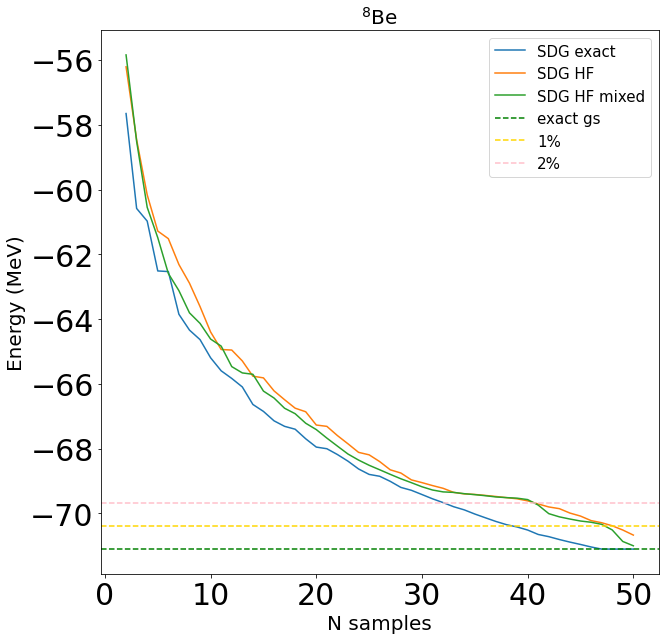

(49,)


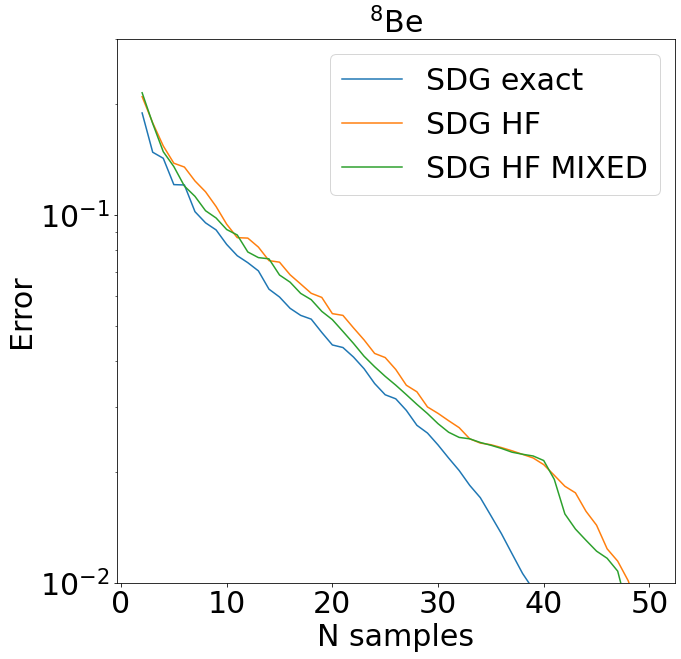

In [19]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')

plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogy()
plt.legend(fontsize=30)
plt.show()

#### Method using a Partial Adapt VQE

In [20]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import FermiHubbardHamiltonian
import numpy as np
from src.nuclear_physics_utils import SingleParticleState,get_twobody_nuclearshell_model
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
from scipy import sparse
#from adapt_vqe_old import AdaptVQEFermiHubbard

In [21]:
def miquel_constrainer(idxs:List[int]):
    
    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition

def miquel_contrained_3(idx:List[int]):
    size=12    
    i1,i2,j1,j2=idx
    if (i1<size and i2>=size) or (i2<size and i1>=size):
        condition=True
    else:
        condition=False
        
    return condition
    


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

       
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

In [22]:
operator_pool:Dict={}
operator_pool=NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer,miquel_constrainer_2],nbody='two')

print(len(operator_pool))



145


In [23]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(NSMHamiltonian.basis):
    psi = np.zeros(NSMHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ NSMHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        b_min=b
        print(value)
        print(b)
        psi_base = psi
        
psi_initial=psi_base

-61.06530000000002
[1 1 1 1 0 0 1 1 1 1 0 0]


In [24]:
# %%
random=False




model=AdaptVQEFermiHubbard()

model.set_hamiltonian(NSMHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf,energy_gs=egs[0])
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='BFGS',tolerance_opt=10**-5,tolerance_adapt=10**-5)

fit.configuration_checkpoint=model.callback
fit.init_model(model)
history_energy,history_grad=fit.run()


/home/ecosta/Quantum-Machine-Learning-on-Fermions/src/qml_utils/train.py:40: OptimizeWarning: Unknown solver options: ftol
  res = minimize(


Optimization Success= True
weights= [-0.08159547]
energy=-68.50797
energy=-71.09942
de=10000000000000000905969664.000000000
TOT_OPERATION_METRIC=9
LAYERS= 1
gradient selected= 1.7980291059074447 

Optimization Success= True
weights= [-0.08343832 -0.08343843]
energy=-68.58474
energy=-71.09942
de=0.076766879
TOT_OPERATION_METRIC=59
LAYERS= 2
gradient selected= 1.8379172323056832 

Optimization Success= True
weights= [-0.08848195 -0.08845056  0.10737272]
energy=-68.67258
energy=-71.09942
de=0.087845736
TOT_OPERATION_METRIC=146
LAYERS= 3
gradient selected= 1.6312711319380229 

Optimization Success= True
weights= [-0.09600444 -0.0960045   0.11969686  0.11969706]
energy=-68.77982
energy=-71.09942
de=0.107239933
TOT_OPERATION_METRIC=410
LAYERS= 4
gradient selected= 1.7871625822197068 

Optimization Success= True
weights= [-0.09449971 -0.0975543   0.1234119   0.12746318  0.07711327]
energy=-68.83542
energy=-71.09942
de=0.055594785
TOT_OPERATION_METRIC=805
LAYERS= 5
gradient selected= 1.4377416

KeyboardInterrupt: 

In [25]:
psi_vqe=model.compute_psi(model.weights)
print(psi_vqe.conjugate().dot(psi_hf)*np.conjugate(psi_vqe.conjugate().dot(psi_hf)))
print(model.weights)

0.8139437830262016
[-0.15457371 -0.16136112  0.18945313  0.19895148  0.33437473  0.31045211
  0.23469057  0.20961466  0.3352224  -0.34192047  0.22828573 -0.22594297
 -0.10460804 -0.14829843 -0.11736592 -0.11785989 -0.21224272  0.20788306
 -0.20691224 -0.12869868 -0.09116207  0.        ]


In [26]:
prob_vqe=np.conjugate(psi_vqe)*psi_vqe

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_vqe=[]
energies_sdg_vqe=[]
fidelities_vqe=[]
deviations_vqe=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_vqe)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_vqe.append(ensamble_fidelity)
        errors_sdg_vqe.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_vqe.append(ensamble_energy)
        deviations_vqe.append(std_energy)
        print(ensamble_energy)


-55.5837113925594
-59.48796442015369
-61.11755706114949
-61.85901264083148
-62.59800377243144
-63.396078496480925
-63.960241824416855
-64.35088287946577
-64.80178365704347
-65.30221355948947
-65.5682891541824
-65.87728337381571
-65.96135842196784
-66.39551690942379
-66.64145321335208
-66.93950636466306
-67.03081270932427
-67.30145340557577
-67.4421948694418
-67.67028264771214
-67.81543641009772
-67.94976932205289
-68.11309550609081
-68.40403161060503
-68.47361359461156
-68.69728376687588
-68.82774221531416
-68.99371962672187
-69.06725736540164
-69.1935146851654
-69.36230671476427
-69.51853696687479
-69.58962003922626
-69.72869458527
-69.85112419167517
-69.9841842645084
-70.0665492048054
-70.14875551903953
-70.25964091428577
-70.36142069050825
-70.42999980858608
-70.51042115246437
-70.58628444442698
-70.65269930500122
-70.71206629313157
-70.77752875483438
-70.86096820124216
-70.91840314089332
-71.0119320056297


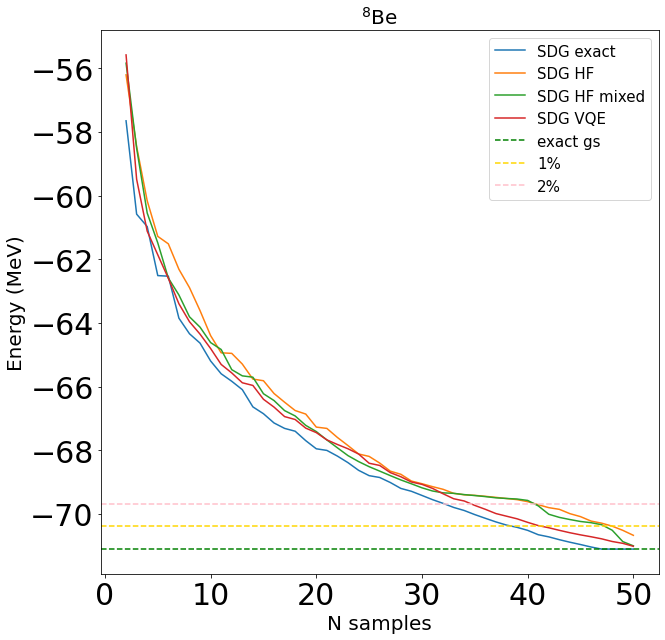

(49,)


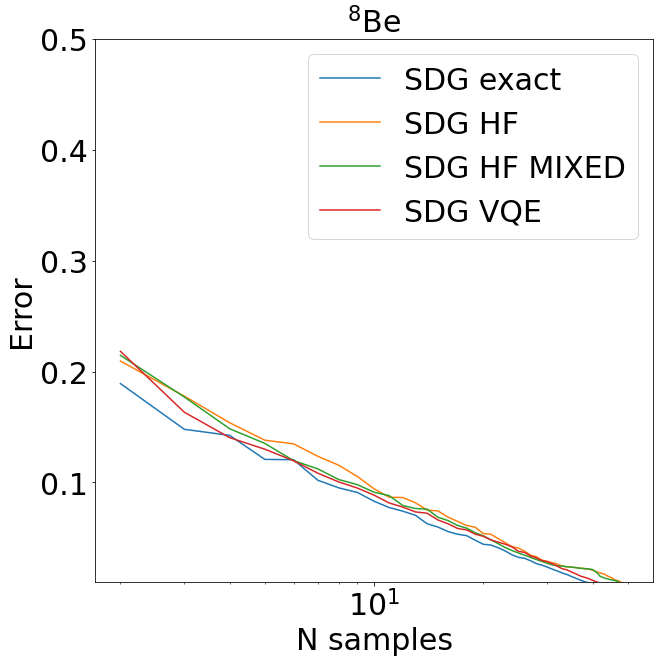

In [27]:
plt.figure(figsize=(10,10))
deviations_vqe=np.abs(np.asarray(deviations_vqe))
deviations=np.abs(np.asarray(deviations))
deviations_exact=np.abs(np.asarray(deviations_exact))
deviations_mixed=np.abs(np.asarray(deviations_mixed))
# plt.errorbar(ns_instances,energies_sdg_gs,yerr=deviations_exact[:,0],label='SDG exact')
# plt.errorbar(ns_instances,energies_sdg_hf,yerr=deviations[:,0],label='SDG HF')
# plt.errorbar(ns_instances,energies_sdg_hf_mixed,yerr=deviations_mixed[:,0],label='SDG HF mixed')
# plt.errorbar(ns_instances,energies_sdg_vqe,yerr=deviations_vqe[:,0],label='SDG VQE')

plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
plt.plot(ns_instances,energies_sdg_vqe,label='SDG VQE')

#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
energies_sdg_vqe=np.asarray(energies_sdg_vqe)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')
plt.plot(ns_instances,np.abs((energies_sdg_vqe-egs[0])/egs[0]),label='SDG VQE')
plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogx()
plt.ylim([0.01,0.5])
plt.legend(fontsize=30)
plt.show()